Feature scaling is a common preprocessing step that adjusts the range or distribution of numerical features. Many machine learning algorithms perform better or converge faster when features are on a similar scale.

## Feature Scaling Numerical Data in Python

This document covers:

* **Why Scale:** Explains the importance of scaling for different types of ML algorithms.
* **Train-Test Split:** Emphasizes splitting data before fitting scalers.
* **`StandardScaler`:** Demonstrates Z-score scaling (mean=0, std=1).
* **`MinMaxScaler`:** Demonstrates scaling features to a `[0, 1]` range.
* **`RobustScaler`:** Demonstrates scaling using median and IQR, making it robust to outliers.
* **Choosing a Scaler:** Provides guidance on when to use each type.
* **Implementation Notes:** Reinforces the critical fit-on-train, transform-both workflow to prevent data leakage.

---

Scaling is a standard preprocessing step for many modeling tasks.

--- Original Data ---
   Feature1     Feature2   Feature3
0  3.745401   531.429186  43.199753
1  9.507143  1136.410411  52.322537
2  7.319939   814.355981  52.930725
3  5.986585  1008.570691  42.856486
4  1.560186  1407.566474  68.657745

Original Data Description:
         Feature1     Feature2    Feature3
count  100.000000   100.000000  100.000000
mean     4.701807   997.831723   51.422926
std      2.974894   293.111253   20.285786
min      0.055221   506.952131  -20.000000
25%      1.932008   742.004526   42.637910
50%      4.641425  1005.624857   51.634530
75%      7.302031  1266.183598   56.812634
max      9.868869  1485.650454  160.000000


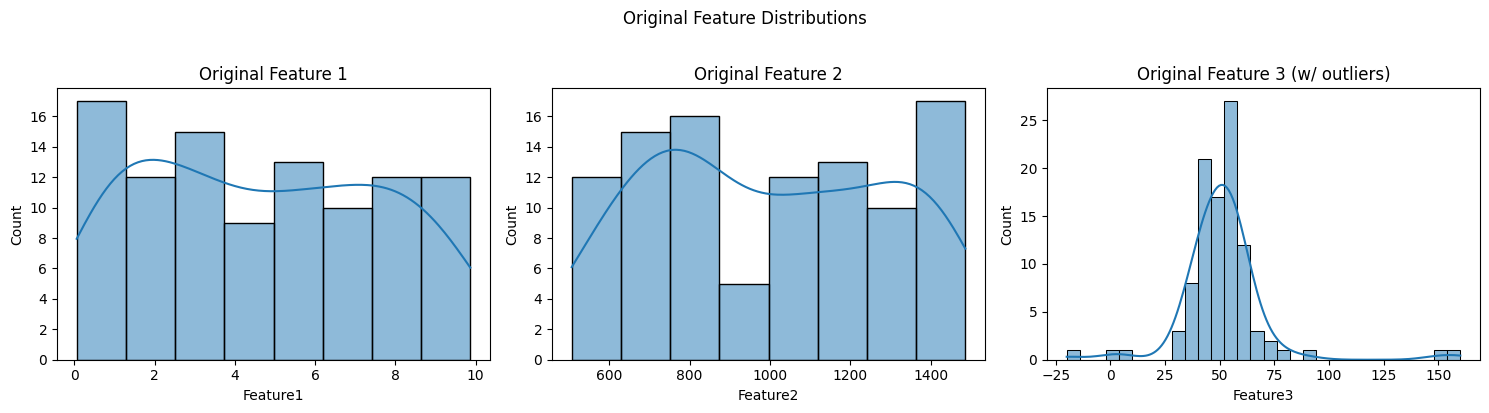

------------------------------
Training set shape: (75, 3)
Test set shape: (25, 3)
------------------------------
--- Standardization (StandardScaler) ---
Scaled Training Data (StandardScaler) - First 5 rows:
     Feature1  Feature2  Feature3
15 -0.984922  1.258910  0.765842
40 -1.204308  1.569310  0.026499
96  0.228188  0.762522  4.765602
9   0.890783 -1.451450  0.278259
72 -1.620857  0.032933 -0.274927

Scaled Training Data Description:
       Feature1  Feature2  Feature3
count     75.00     75.00     75.00
mean      -0.00     -0.00     -0.00
std        1.01      1.01      1.01
min       -1.62     -1.69     -3.14
25%       -0.94     -0.89     -0.39
50%        0.05      0.03     -0.04
75%        0.89      0.92      0.22
max        1.83      1.65      4.77


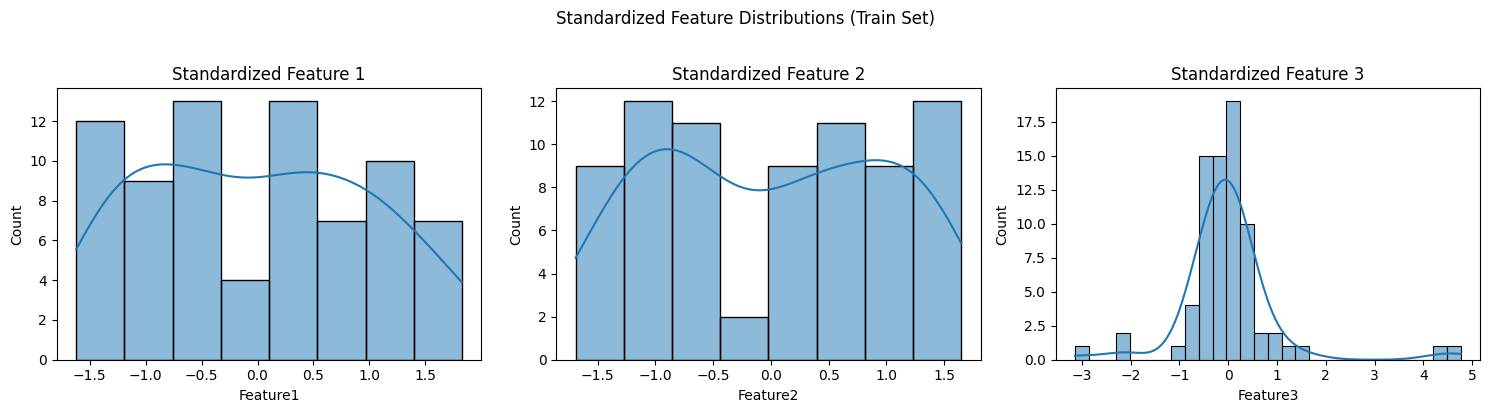

------------------------------
--- Normalization (MinMaxScaler) ---
Scaled Training Data (MinMaxScaler) - First 5 rows:
     Feature1  Feature2  Feature3
15  0.184451  0.883325  0.494266
40  0.120819  0.976292  0.400783
96  0.536310  0.734653  1.000000
9   0.728494  0.071552  0.432616
72  0.000000  0.516135  0.362670

Scaled Training Data Description:
       Feature1  Feature2  Feature3
count     75.00     75.00     75.00
mean       0.47      0.51      0.40
std        0.29      0.30      0.13
min        0.00      0.00      0.00
25%        0.20      0.24      0.35
50%        0.48      0.52      0.39
75%        0.73      0.78      0.43
max        1.00      1.00      1.00


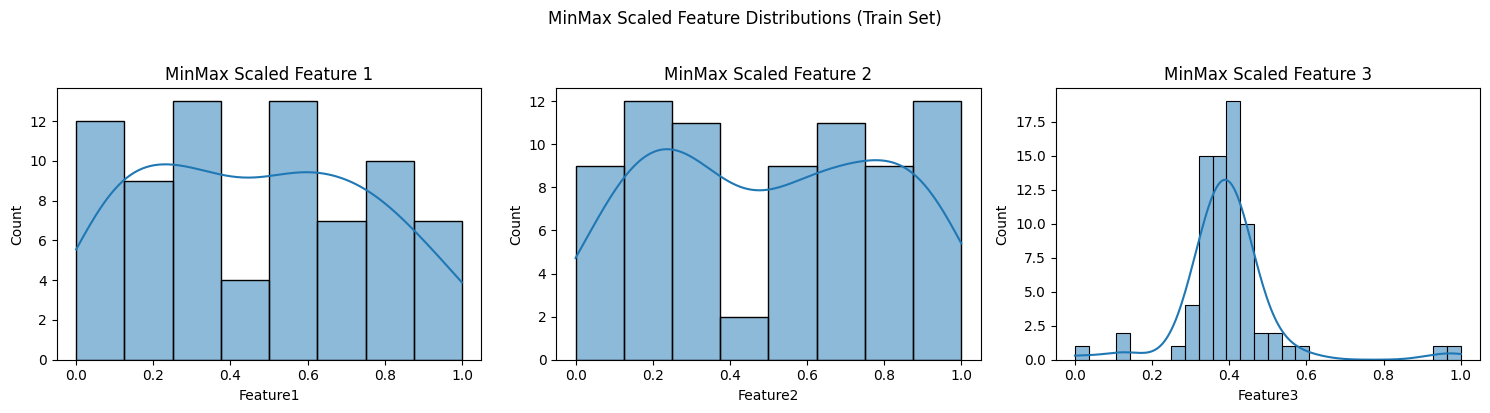

------------------------------
--- Robust Scaling (RobustScaler) ---
Scaled Training Data (RobustScaler) - First 5 rows:
     Feature1  Feature2  Feature3
15 -0.566167  0.678000  1.312666
40 -0.686465  0.849660  0.107315
96  0.099032  0.403484  7.833477
9   0.462361 -0.820905  0.517759
72 -0.914876  0.000000 -0.384099

Scaled Training Data Description:
       Feature1  Feature2  Feature3
count     75.00     75.00     75.00
mean      -0.03     -0.02      0.06
std        0.55      0.56      1.64
min       -0.91     -0.95     -5.06
25%       -0.54     -0.51     -0.58
50%        0.00      0.00      0.00
75%        0.46      0.49      0.42
max        0.98      0.89      7.83


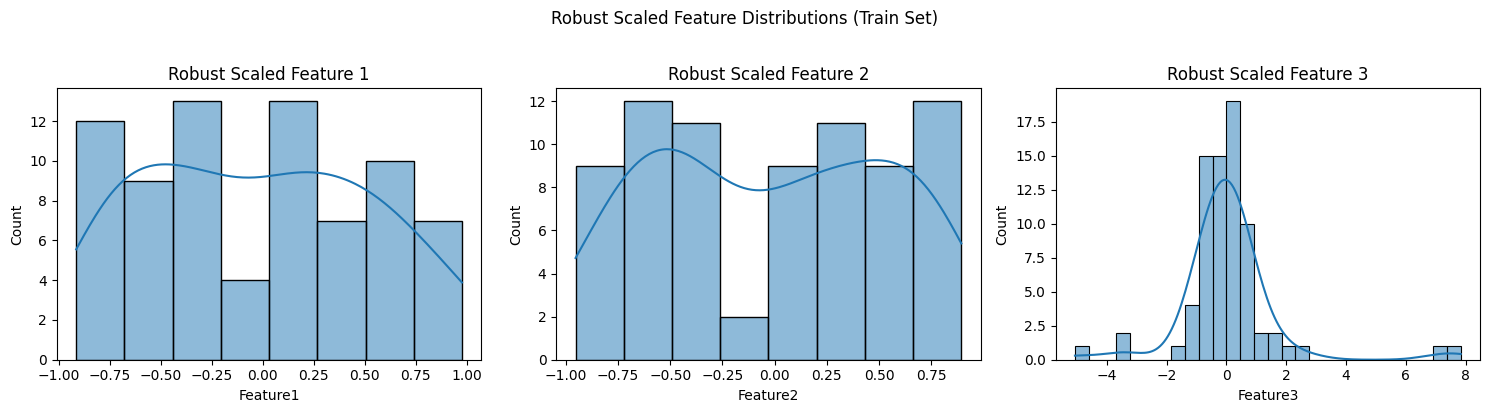

------------------------------
--- Choosing a Scaler ---
- StandardScaler: Good default choice, especially if you expect data to be somewhat normally distributed.
- MinMaxScaler: Useful when features need to be bounded in [0, 1] (e.g., image pixels, inputs to some neural networks). Sensitive to outliers.
- RobustScaler: Use when your data contains significant outliers that might negatively impact StandardScaler or MinMaxScaler.
- Remember tree-based models (Decision Trees, Random Forests) generally don't require feature scaling.
------------------------------
--- Implementation Notes ---
1. Split data into Training and Test sets FIRST.
2. Fit the chosen scaler ONLY on the Training data (scaler.fit(X_train)).
3. Transform BOTH the Training and Test data using the fitted scaler
   (X_train_scaled = scaler.transform(X_train), X_test_scaled = scaler.transform(X_test)).
4. Integrate scaling into Pipelines (Section VIII) for robust workflows, especially with cross-validation.
---------------

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Why Scale Features? ---
# - Algorithms using distance metrics (KNN, K-Means, SVM with RBF kernel) are sensitive to feature scales.
#   Features with larger ranges can dominate the distance calculation.
# - Gradient descent-based algorithms (Linear/Logistic Regression, Neural Networks) converge faster
#   when features are on similar scales.
# - Regularization techniques (L1/L2) apply penalties based on coefficient size, which assumes
#   features have comparable scales.
# - Note: Tree-based models (Decision Trees, Random Forests, Gradient Boosting) are generally
#   *not* sensitive to feature scaling, as they split based on thresholds within individual features.

# --- 2. Create Sample Data ---
np.random.seed(42)
data = pd.DataFrame({
    # Feature with relatively small range
    'Feature1': np.random.rand(100) * 10,
    # Feature with larger range and different mean
    'Feature2': np.random.rand(100) * 1000 + 500,
    # Feature with some outliers
    'Feature3': np.concatenate([np.random.normal(50, 10, 95), np.array([150, 160, 1, 5, -20])])
})

print("--- Original Data ---")
print(data.head())
print("\nOriginal Data Description:")
print(data.describe())

# Visualize original distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(data['Feature1'], kde=True, ax=axes[0]).set_title('Original Feature 1')
sns.histplot(data['Feature2'], kde=True, ax=axes[1]).set_title('Original Feature 2')
sns.histplot(data['Feature3'], kde=True, ax=axes[2]).set_title('Original Feature 3 (w/ outliers)')
plt.suptitle("Original Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()
print("-" * 30)


# --- 3. Train-Test Split (CRITICAL STEP!) ---
# Fit scalers ONLY on training data to avoid data leakage from the test set.
X_train, X_test = train_test_split(data, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("-" * 30)


# --- 4. Technique 1: Standardization (StandardScaler) ---
# Transforms data to have zero mean (μ=0) and unit variance (σ=1).
# Formula: z = (x - μ) / σ
# Good general-purpose scaler, less affected by outliers than MinMaxScaler.

print("--- Standardization (StandardScaler) ---")
scaler_standard = StandardScaler()

# Fit the scaler on the training data ONLY
scaler_standard.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler_standard.transform(X_train)
X_test_scaled = scaler_standard.transform(X_test)

# Convert back to DataFrame for easier viewing/plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=data.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=data.columns, index=X_test.index)

print("Scaled Training Data (StandardScaler) - First 5 rows:\n", X_train_scaled_df.head())
print("\nScaled Training Data Description:")
print(X_train_scaled_df.describe().round(2)) # Mean should be ~0, Std Dev ~1

# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(X_train_scaled_df['Feature1'], kde=True, ax=axes[0]).set_title('Standardized Feature 1')
sns.histplot(X_train_scaled_df['Feature2'], kde=True, ax=axes[1]).set_title('Standardized Feature 2')
sns.histplot(X_train_scaled_df['Feature3'], kde=True, ax=axes[2]).set_title('Standardized Feature 3')
plt.suptitle("Standardized Feature Distributions (Train Set)", y=1.02)
plt.tight_layout()
plt.show()
print("-" * 30)


# --- 5. Technique 2: Normalization (MinMaxScaler) ---
# Rescales data to a fixed range, typically [0, 1].
# Formula: x_scaled = (x - min(x)) / (max(x) - min(x))
# Sensitive to outliers (min/max values determine the range).

print("--- Normalization (MinMaxScaler) ---")
scaler_minmax = MinMaxScaler(feature_range=(0, 1)) # Default range is [0, 1]

# Fit the scaler on the training data ONLY
scaler_minmax.fit(X_train)

# Transform both training and test data
X_train_minmax = scaler_minmax.transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# Convert back to DataFrame
X_train_minmax_df = pd.DataFrame(X_train_minmax, columns=data.columns, index=X_train.index)
X_test_minmax_df = pd.DataFrame(X_test_minmax, columns=data.columns, index=X_test.index)

print("Scaled Training Data (MinMaxScaler) - First 5 rows:\n", X_train_minmax_df.head())
print("\nScaled Training Data Description:")
print(X_train_minmax_df.describe().round(2)) # Min should be ~0, Max ~1

# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(X_train_minmax_df['Feature1'], kde=True, ax=axes[0]).set_title('MinMax Scaled Feature 1')
sns.histplot(X_train_minmax_df['Feature2'], kde=True, ax=axes[1]).set_title('MinMax Scaled Feature 2')
sns.histplot(X_train_minmax_df['Feature3'], kde=True, ax=axes[2]).set_title('MinMax Scaled Feature 3')
plt.suptitle("MinMax Scaled Feature Distributions (Train Set)", y=1.02)
plt.tight_layout()
plt.show()
# Note how outliers in Feature3 might compress the majority of data
print("-" * 30)


# --- 6. Technique 3: Robust Scaling (RobustScaler) ---
# Uses statistics robust to outliers: scales data according to the Interquartile Range (IQR).
# Removes the median and scales data according to the quantile range (default IQR: Q1 to Q3).
# Formula (approx): x_scaled = (x - median) / IQR
# Less sensitive to outliers than StandardScaler or MinMaxScaler.

print("--- Robust Scaling (RobustScaler) ---")
scaler_robust = RobustScaler(quantile_range=(25.0, 75.0)) # Default IQR

# Fit the scaler on the training data ONLY
scaler_robust.fit(X_train)

# Transform both training and test data
X_train_robust = scaler_robust.transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

# Convert back to DataFrame
X_train_robust_df = pd.DataFrame(X_train_robust, columns=data.columns, index=X_train.index)
X_test_robust_df = pd.DataFrame(X_test_robust, columns=data.columns, index=X_test.index)

print("Scaled Training Data (RobustScaler) - First 5 rows:\n", X_train_robust_df.head())
print("\nScaled Training Data Description:")
print(X_train_robust_df.describe().round(2)) # Median should be ~0

# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(X_train_robust_df['Feature1'], kde=True, ax=axes[0]).set_title('Robust Scaled Feature 1')
sns.histplot(X_train_robust_df['Feature2'], kde=True, ax=axes[1]).set_title('Robust Scaled Feature 2')
sns.histplot(X_train_robust_df['Feature3'], kde=True, ax=axes[2]).set_title('Robust Scaled Feature 3')
plt.suptitle("Robust Scaled Feature Distributions (Train Set)", y=1.02)
plt.tight_layout()
plt.show()
# Note how Feature3's distribution might look less squashed compared to MinMaxScaler
print("-" * 30)


# --- 7. Choosing a Scaler ---
print("--- Choosing a Scaler ---")
print("- StandardScaler: Good default choice, especially if you expect data to be somewhat normally distributed.")
print("- MinMaxScaler: Useful when features need to be bounded in [0, 1] (e.g., image pixels, inputs to some neural networks). Sensitive to outliers.")
print("- RobustScaler: Use when your data contains significant outliers that might negatively impact StandardScaler or MinMaxScaler.")
print("- Remember tree-based models (Decision Trees, Random Forests) generally don't require feature scaling.")
print("-" * 30)


# --- 8. Implementation Notes (Recap) ---
print("--- Implementation Notes ---")
print("1. Split data into Training and Test sets FIRST.")
print("2. Fit the chosen scaler ONLY on the Training data (scaler.fit(X_train)).")
print("3. Transform BOTH the Training and Test data using the fitted scaler")
print("   (X_train_scaled = scaler.transform(X_train), X_test_scaled = scaler.transform(X_test)).")
print("4. Integrate scaling into Pipelines (Section VIII) for robust workflows, especially with cross-validation.")
print("-" * 30)